# Tradesimple AI project

Identifying future prospects of a company is hard to grasp from past endeavors only. The earliest signs come in the form of chatter in the media and amongst individuals. As students in our early 20’s, we can leverage the power of compounding. Though, investing in the stock market can be very intimidating for younger individuals just starting their careers. We are looking for assurance that the money we invest will be able to grow over the years. 

In [ ]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import numpy as np
from numpy import random
import math
import quantstats as qs
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [ ]:
# Inspiration: https://ark-invest.com/articles/analyst-research/tesla-price-target-2/?utm_content=158811503&utm_medium=social&utm_source=linkedin&hss_channel=lcp-5103566&fbclid=IwAR3U49VCassNb20jWyDUb1RUa3cY5dBbdW4eH8CcSNtxdGxOUvU262w4e3c
# Source: https://www.investopedia.com/terms/m/montecarlosimulation.asp
'''INPUT______________
portfolio_data: Is the stock price data that has been collected since today
ticker: What ticker we are simulating
num_days: How many days to simulate
simulation_count: How many simulations to run
color: What color to use to visualise the graph
OUTPUT_____________
'''


# Here we will use the adjusted close price as it is a better representation of the value of the stock
def monteCarloSim(ticker, num_days, simulation_count,start, end):
    portfolio_data = web.DataReader(ticker,'yahoo', start, end)['Open']
    volatility = portfolio_data.pct_change().std()# Might switch it to log return .apply(lambda x: np.log(1 + x))
    lastprice = portfolio_data.loc[start]
    last_price_date = portfolio_data.index[0]
    drift = portfolio_data.pct_change().mean() - (portfolio_data.pct_change().var()/2)
    date_list = [last_price_date + dt.timedelta(days=x) for x in range(num_days+1)][1:]
    sim_df = pd.DataFrame(index = date_list)
    np.random.seed(4106)
    for i in range(simulation_count): # We multiple simulations 
        priceseries = list()
        for y in range(num_days):
            shock = (np.random.normal(0,volatility))
            if y == 0:
                price = lastprice * math.exp(drift + shock) # ​Next Day’s Price=Today’s Price × e^(Drift+Random Value)
                priceseries.append(price)
            else:
                price = max(0, priceseries[y-1] * math.exp(drift + shock)) # ​Next Day’s Price=Today’s Price × e^(Drift+Random Value)
                priceseries.append(price)
        sim_df[i] = priceseries
    # print("Blue Mean Cummulative Return ",ticker,": ",sim_df.pct_change().mean().sum() * 100, "%")
    # plt.figure(figsize=(12,5))
    # plt.title(ticker)
    # g = sns.histplot(sim_df.pct_change().sum()*100,kde = True, bins = 10, label=ticker)
    # g.axvline(sim_df.pct_change().sum().mean() * 100, color="blue")
    
    # sim_df.plot(figsize=(12,10), linestyle="dashed", label="sum", legend = False, title=ticker)
    mean = qs.stats.sharpe(sim_df).mean()
    sharpes = qs.stats.sharpe(sim_df).sort_values()
    bull = sharpes[sharpes >= mean].reset_index()['index']
    bull = bull[np.random.randint(0,bull.size)]

    bear = sharpes[sharpes < mean].reset_index()['index']
    bear = bear[np.random.randint(0,bear.size)]
    # print("Bear : ",qs.stats.sharpe(sim_df[bear]))
    # print("Mean : ",mean)
    # print("Bull : ",qs.stats.sharpe(sim_df[bull]))
    # g.axvline(sim_df[bear].pct_change().sum() * 100, color="green")
    # g.axvline(sim_df[bull].pct_change().sum() * 100, color="green")
    # plt.show()
    


    return qs.stats.sharpe(sim_df[bear]), qs.stats.sharpe(sim_df[bull])

# start = dt.datetime(2019,11,27)
# end = start + dt.timedelta(days=14)
# monteCarloSim("TSLA", 14, 400, start, end)

## Reinforcement Learning 

In [ ]:
start = dt.datetime(2019,10,1)
start_predicting = dt.datetime(2019,11,5)
end = dt.datetime(2020,10,30)
df = web.DataReader('TSLA','yahoo', start, end)
df['Bearish Sharpe Ratio'], df['Bullish Sharpe Ratio'] = [0, 0]
count = 0
for i, row in df.iterrows():
    if i >= start_predicting:
        start = df.index[count - 14] 
        print(count," : ",start, i)
        df['Bearish Sharpe Ratio'].loc[i], df['Bullish Sharpe Ratio'].loc[i] = monteCarloSim("TSLA", 14, 150, start, i)
    count +=1
df # Takes 4 minutes


In [ ]:
# Data Preparation with Sentiment
sentiment_df = pd.read_csv("sentimentInformation.csv") 
sentiment_df = sentiment_df[['Date', 'Result']]
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df = sentiment_df.set_index('Date')
joined_df = df.join(sentiment_df, how = 'inner').sort_index() # removing data from weekends when there is no trading
joined_df

,High,Low,Open,Close,Volume,Adj Close,Bearish Sharpe Ratio,Bullish Sharpe Ratio,Result
Date,,,,,,,,,
2019-11-05,64.702003,63.223999,63.924000,63.444000,34717000.0,63.444000,-0.402033,6.877432,1.0
2019-11-07,68.300003,65.603996,65.828003,67.108002,72336500.0,67.108002,-0.093696,7.137966,0.0
2019-11-13,71.265999,69.036003,71.000000,69.222000,42100500.0,69.222000,1.516495,8.572674,0.0
2019-11-21,72.167999,70.800003,70.902000,70.966003,30550000.0,70.966003,2.453394,9.502299,-1.0
2019-11-29,66.251999,65.500000,66.222000,65.987999,12328000.0,65.987999,-5.365439,1.063480,-1.0
...,...,...,...,...,...,...,...,...,...
2020-10-23,422.890015,407.380005,421.839996,420.630005,33717000.0,420.630005,-4.953100,1.424855,1.0
2020-10-26,425.760010,410.000000,411.630005,420.279999,28239200.0,420.279999,-6.251375,0.527450,1.0
2020-10-27,430.500000,420.100006,423.760010,424.679993,22686500.0,424.679993,-4.542502,1.918114,0.0


In [ ]:
import gym_anytrading
import gym 
from gym_anytrading.envs import StocksEnv
from stable_baselines3 import PPO

## Model 1

Environment: Our agent can observe the past 5 days
Action: Buy or Sell
The green and red dots: Whether it is taking a short or long position


Information :  {'total_reward': 276.0559997558594, 'total_profit': 2.167202601930748, 'position': 0}


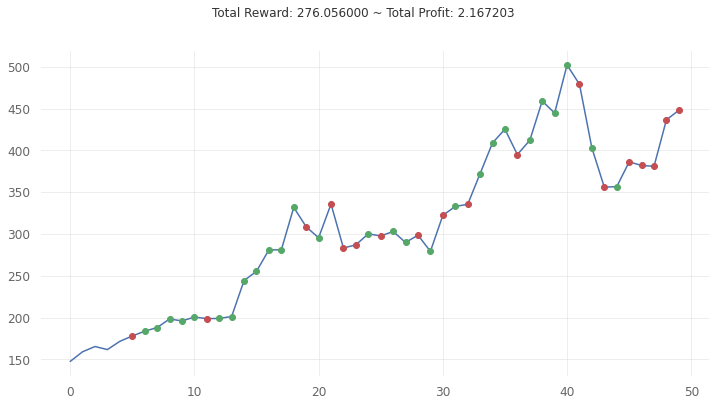

In [ ]:
def add_signals_m1(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Open'].to_numpy()[start:end]
    signals = env.df.loc[:,['Open']].to_numpy()[start:end]
    return prices, signals

class CustomEnv1(StocksEnv):
    _process_data = add_signals_m1

model1Env = CustomEnv1(df=joined_df, frame_bound = (5, 55), window_size = 5)
model1 = PPO('MlpPolicy', model1Env, seed = 4106)
model1.learn(total_timesteps= 50000)
model1Env = CustomEnv1(df=joined_df, frame_bound = (55, 100), window_size = 5)
obs = model1Env.reset()

while True:
    obs = obs[np.newaxis,...]
    action, _states = model1.predict(obs)
    obs, reward, done, info = model1Env.step(action)
    if done:
        print("Information : ", info)
        plt.figure(figsize=(12,6))
        model1Env.render_all()
        plt.show()
        break

Information :  {'total_reward': 92.70201110839844, 'total_profit': 1.1586723906425247, 'position': 0}


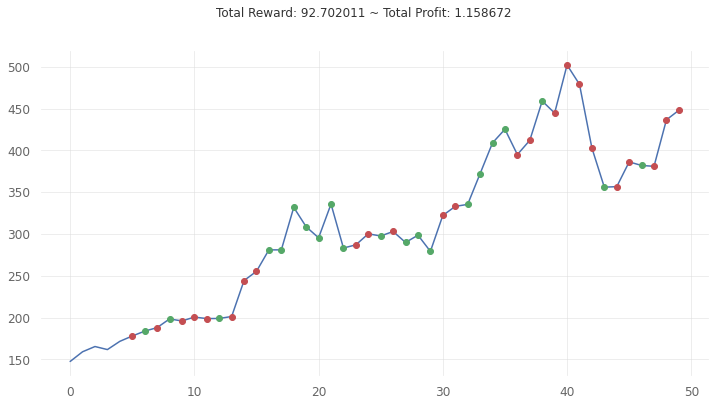

In [ ]:
obs = model1Env.reset()
while True:
    obs = obs[np.newaxis,...]
    action, _states = model1.predict(obs)
    action = np.array(random.randint(0, 2)).astype(int)
    obs, reward, done, info = model1Env.step(action)
    if done:
        print("Information : ", info)
        plt.figure(figsize=(12,6))
        model1Env.render_all()
        plt.show()
        break

## Model 2



Information :  {'total_reward': 57.692047119140625, 'total_profit': 1.1124050546844082, 'position': 1}


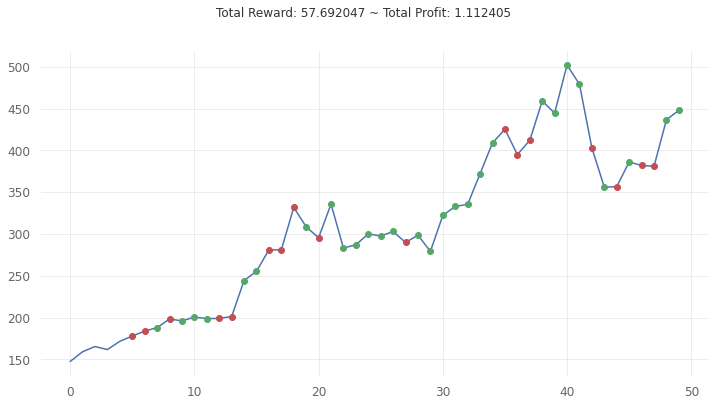

In [ ]:
def add_signals_m2(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Open'].to_numpy()[start:end]
    signals = env.df.loc[:,['Open','Result']].to_numpy()[start:end]
    return prices, signals

    
class CustomEnv2(StocksEnv):
    _process_data = add_signals_m2

model2Env = CustomEnv2(df=joined_df, frame_bound = (5, 55), window_size = 5)
model2 = PPO('MlpPolicy', model2Env, seed = 4106)
model2.learn(total_timesteps= 50000)
model2Env = CustomEnv2(df=joined_df, frame_bound = (55, 100), window_size = 5)
obs = model2Env.reset()

while True:
    obs = obs[np.newaxis,...]
    action, _states = model2.predict(obs)
    obs, reward, done, info = model2Env.step(action)
    if done:
        print("Information : ", info)
        plt.figure(figsize=(12,6))
        model2Env.render_all()
        plt.show()
        break



## Model 3

Information :  {'total_reward': 20.293914794921875, 'total_profit': 0.9844848223879933, 'position': 0}


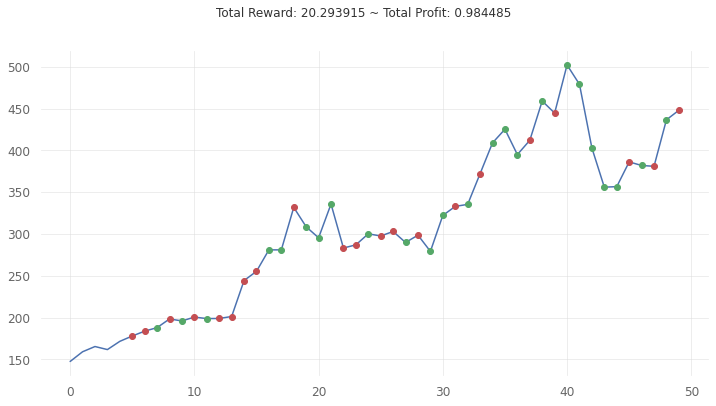

In [ ]:
def add_signals_m3(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Open'].to_numpy()[start:end]
    signals = env.df.loc[:,['Open','Bearish Sharpe Ratio','Bullish Sharpe Ratio']].to_numpy()[start:end]
    return prices, signals
    
class CustomEnv3(StocksEnv):
    _process_data = add_signals_m3

model3Env = CustomEnv3(df=joined_df, frame_bound = (5, 55), window_size = 5)
model3 = PPO('MlpPolicy', model3Env, seed = 4106)
model3.learn(total_timesteps= 50000)
model3Env = CustomEnv3(df=joined_df, frame_bound = (55, 100), window_size = 5)
obs = model3Env.reset()

while True:
    obs = obs[np.newaxis,...]
    action, _states = model3.predict(obs)
    obs, reward, done, info = model3Env.step(action)
    if done:
        print("Information : ", info)
        plt.figure(figsize=(12,6))
        model3Env.render_all()
        plt.show()
        break

## Model 4

Information :  {'total_reward': 163.798095703125, 'total_profit': 1.6309040660260836, 'position': 1}


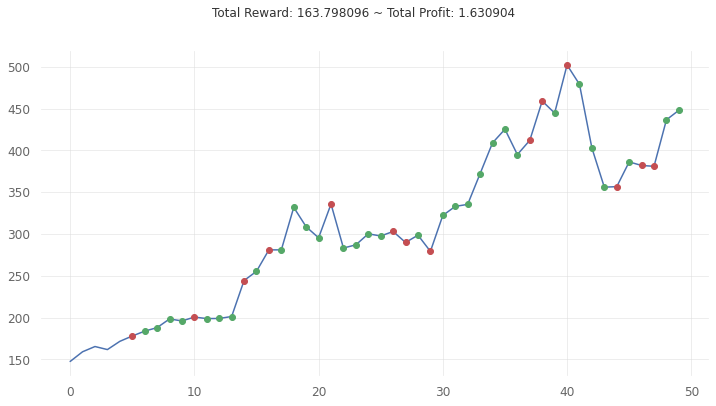

In [ ]:
def add_signals_m4(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Open'].to_numpy()[start:end]
    signals = env.df.loc[:,['Open','Bearish Sharpe Ratio','Bullish Sharpe Ratio','Result']].to_numpy()[start:end]
    return prices, signals

class CustomEnv4(StocksEnv):
    _process_data = add_signals_m4

model4Env = CustomEnv4(df=joined_df, frame_bound = (5, 55), window_size = 5)
model4 = PPO('MlpPolicy', model4Env, seed = 4106)
model4.learn(total_timesteps= 50000)
model4Env = CustomEnv4(df=joined_df, frame_bound = (55, 100), window_size = 5)
obs = model4Env.reset()

while True:
    obs = obs[np.newaxis,...]
    action, _states = model4.predict(obs)
    obs, reward, done, info = model4Env.step(action)
    if done:
        print("Information : ", info)
        plt.figure(figsize=(12,6))
        model4Env.render_all()
        plt.show()
        break

In [ ]:
print("> max_possible_profit:", model4Env.max_possible_profit())


> max_possible_profit: 6.3634569838043795


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3199436c-4945-4a54-b3fa-76d3009af8b2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>